In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, models
from transformers import AutoModel, AutoImageProcessor
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = OxfordIIITPet(root='./data', split='trainval', target_types='segmentation', transform=transform, download=True)

def otsu_threshold(image_array):
    pixel_counts = np.bincount(image_array.flatten(), minlength=256)
    total = image_array.size
    sum_total = np.dot(np.arange(256), pixel_counts)
    sum_bg, weight_bg, max_var, threshold = 0.0, 0.0, 0.0, 0
    for t in range(256):
        weight_bg += pixel_counts[t]
        if weight_bg == 0: continue
        weight_fg = total - weight_bg
        if weight_fg == 0: break
        sum_bg += t * pixel_counts[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg
        var_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2
        if var_between > max_var:
            max_var = var_between
            threshold = t
    return threshold / 255.0

def erode(mask, k=3):
    pad = k // 2
    padded = np.pad(mask, pad, mode='constant')
    out = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            out[i, j] = np.min(padded[i:i+k, j:j+k])
    return out

def dilate(mask, k=3):
    pad = k // 2
    padded = np.pad(mask, pad, mode='constant')
    out = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            out[i, j] = np.max(padded[i:i+k, j:j+k])
    return out

def open_then_close(mask):
    return dilate(erode(mask))

def keep_largest_component(mask):
    labeled = np.zeros_like(mask, dtype=int)
    current_label = 1
    max_size = 0
    max_mask = np.zeros_like(mask)
    visited = np.zeros_like(mask, dtype=bool)
    H, W = mask.shape
    for i in range(H):
        for j in range(W):
            if mask[i, j] == 1 and not visited[i, j]:
                stack = [(i, j)]
                visited[i, j] = True
                region = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < H and 0 <= ny < W and not visited[nx, ny] and mask[nx, ny] == 1:
                                visited[nx, ny] = True
                                stack.append((nx, ny))
                                region.append((nx, ny))
                if len(region) > max_size:
                    max_size = len(region)
                    max_mask = np.zeros_like(mask)
                    for x, y in region:
                        max_mask[x, y] = 1
    return max_mask.astype(np.uint8)

def simple_edge_detection(mask):
    h, w = mask.shape
    edge = np.zeros_like(mask)
    for i in range(1, h-1):
        for j in range(1, w-1):
            patch = mask[i-1:i+2, j-1:j+2]
            if patch.max() != patch.min():
                edge[i, j] = 1
    return edge.astype(np.uint8)

vit_model = AutoModel.from_pretrained("facebook/dino-vits16", output_attentions=True).to(device).eval()
vit_processor = AutoImageProcessor.from_pretrained("facebook/dino-vits16")

def extract_vit_mask(img_pil, threshold=None, selected_layers=[5,7,9]):
    w, h = img_pil.size
    inputs = vit_processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit_model(**inputs)
        attn = outputs.attentions
    attn_maps = [attn[i][0].mean(0)[0, 1:] for i in selected_layers]
    cls_attn = torch.stack(attn_maps).mean(0)
    side = int(cls_attn.shape[0] ** 0.5)
    attn_map = cls_attn.reshape(side, side).cpu().numpy()
    attn_map = np.array(Image.fromarray((attn_map * 255).astype(np.uint8)).resize((w, h))) / 255.0
    norm_attn = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-5)
    if threshold is None:
        t = otsu_threshold((norm_attn * 255).astype(np.uint8))
        binary_mask = (norm_attn > t).astype(np.uint8)
    else:
        binary_mask = (norm_attn > threshold).astype(np.uint8)
    cleaned = open_then_close(binary_mask)
    cleaned = keep_largest_component(cleaned)
    edge = simple_edge_detection(cleaned)
    refined = (cleaned & (1 - edge))
    return norm_attn, Image.fromarray(refined * 255).convert("L")

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam_map = torch.relu((weights * self.activations).sum(1)).squeeze().cpu().numpy()
        cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-6)
        return cam_map

def extract_gradcam_mask(img_tensor):
    resnet = models.resnet50(pretrained=True).to(device)
    gradcam = GradCAM(resnet, resnet.layer4[-1])
    cam_map = gradcam(img_tensor.to(device))
    cam_map = np.array(Image.fromarray((cam_map * 255).astype(np.uint8)).resize((224, 224))) / 255.0
    t = otsu_threshold((cam_map * 255).astype(np.uint8))
    binary_mask = (cam_map > t).astype(np.uint8)
    cleaned = open_then_close(binary_mask)
    cleaned = keep_largest_component(cleaned)
    return cam_map, Image.fromarray(cleaned * 255).convert("L")

def fuse_masks(vit_mask, grad_mask, mode="avg"):
    vit_np = (np.array(vit_mask) > 128).astype(np.uint8)
    grad_np = (np.array(grad_mask) > 128).astype(np.uint8)
    if mode == "and":
        fused = vit_np & grad_np
    elif mode == "or":
        fused = vit_np | grad_np
    elif mode == "avg":
        avg = (vit_np + grad_np) / 2.0
        fused = (avg > 0.5).astype(np.uint8)
    else:
        raise ValueError("Unsupported fusion mode")
    fused = open_then_close(fused)
    fused = keep_largest_component(fused)
    edge = simple_edge_detection(fused)
    fused = (fused & (1 - edge)).astype(np.uint8)
    return Image.fromarray(fused * 255).convert("L")

def overlay_attention(img_pil, attn_map):
    img = np.array(img_pil)
    heat = (attn_map * 255).astype(np.uint8)
    heat = np.stack([heat]*3, axis=-1)
    overlay = (0.6 * img + 0.4 * heat).astype(np.uint8)
    return Image.fromarray(overlay)

def show_comparison(img, gt_mask, vit_map, vit_mask, grad_map, grad_mask, fused_mask):
    fig, axs = plt.subplots(1, 7, figsize=(32, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].imshow(gt_mask, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(overlay_attention(img, vit_map))
    axs[2].set_title("ViT Overlay")
    axs[3].imshow(vit_mask, cmap='gray')
    axs[3].set_title("ViT Mask")
    axs[4].imshow(overlay_attention(img, grad_map))
    axs[4].set_title("Grad-CAM Overlay")
    axs[5].imshow(grad_mask, cmap='gray')
    axs[5].set_title("Grad-CAM Mask")
    axs[6].imshow(fused_mask, cmap='gray')
    axs[6].set_title("Fused Mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def compute_metrics(pred_mask, gt_mask):
    pred = (np.array(pred_mask) > 128).astype(np.uint8)
    gt_np = np.array(gt_mask)
    gt = ((gt_np == 1) | (gt_np == 2)).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    dice = 2 * intersection / (pred.sum() + gt.sum() + 1e-6)
    iou = intersection / (union + 1e-6)
    return dice, iou

img_tensor, mask_tensor = dataset[42]
img_tensor_unsqueezed = img_tensor.unsqueeze(0)
img_pil = transforms.ToPILImage()(img_tensor)
gt_mask = mask_tensor.resize((224, 224)).convert("L")

vit_map, vit_mask = extract_vit_mask(img_pil)
grad_map, grad_mask = extract_gradcam_mask(img_tensor_unsqueezed)
fused_mask = fuse_masks(vit_mask, grad_mask)

show_comparison(img_pil, gt_mask, vit_map, vit_mask, grad_map, grad_mask, fused_mask)

vit_dice, vit_iou = compute_metrics(vit_mask, gt_mask)
grad_dice, grad_iou = compute_metrics(grad_mask, gt_mask)
fused_dice, fused_iou = compute_metrics(fused_mask, gt_mask)

print(f"\nViT: Dice={vit_dice:.4f}, IoU={vit_iou:.4f}")
print(f"Grad-CAM: Dice={grad_dice:.4f}, IoU={grad_iou:.4f}")
print(f"Fused: Dice={fused_dice:.4f}, IoU={fused_iou:.4f}")

In [ ]:
import os
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

trainval_dataset = OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    transform=transform,
    download=True
)

def save_fused_pseudo_dataset(dataset, save_dir="pseudo_dataset", n=None):
    os.makedirs(f"{save_dir}/images", exist_ok=True)
    os.makedirs(f"{save_dir}/masks", exist_ok=True)
    if n is None: n = len(dataset)

    for idx in range(n):
        try:
            img_tensor, _ = dataset[idx]
            img_tensor_unsq = img_tensor.unsqueeze(0)
            img_pil = transforms.ToPILImage()(img_tensor)

            _, vit_mask = extract_vit_mask(img_pil)
            _, grad_mask = extract_gradcam_mask(img_tensor_unsq)
            fused_mask = fuse_masks(vit_mask, grad_mask)

            img_pil.save(f"{save_dir}/images/{idx:04d}.png")
            fused_mask.save(f"{save_dir}/masks/{idx:04d}.png")

            if idx % 50 == 0:
                print(f"Saved {idx}/{n}")
        except Exception as e:
            print(f"Failed on index {idx}: {e}")

save_fused_pseudo_dataset(trainval_dataset, save_dir="pseudo_dataset", n=300)


[Epoch 1] Loss: 0.6548
[Epoch 2] Loss: 0.6298
[Epoch 3] Loss: 0.6060
[Epoch 4] Loss: 0.5661
[Epoch 5] Loss: 0.5525
[Epoch 6] Loss: 0.5456
[Epoch 7] Loss: 0.5394
[Epoch 8] Loss: 0.5412
[Epoch 9] Loss: 0.5397
[Epoch 10] Loss: 0.5335
[Epoch 11] Loss: 0.5349
[Epoch 12] Loss: 0.5372
[Epoch 13] Loss: 0.5347
[Epoch 14] Loss: 0.5302
[Epoch 15] Loss: 0.5286
[Epoch 16] Loss: 0.5308
[Epoch 17] Loss: 0.5287
[Epoch 18] Loss: 0.5250
[Epoch 19] Loss: 0.5283
[Epoch 20] Loss: 0.5227
[Epoch 21] Loss: 0.5239
[Epoch 22] Loss: 0.5309
[Epoch 23] Loss: 0.5235
[Epoch 24] Loss: 0.5262
[Epoch 25] Loss: 0.5228
[Epoch 26] Loss: 0.5078
[Epoch 27] Loss: 0.5068
[Epoch 28] Loss: 0.5045
[Epoch 29] Loss: 0.4984
[Epoch 30] Loss: 0.4976


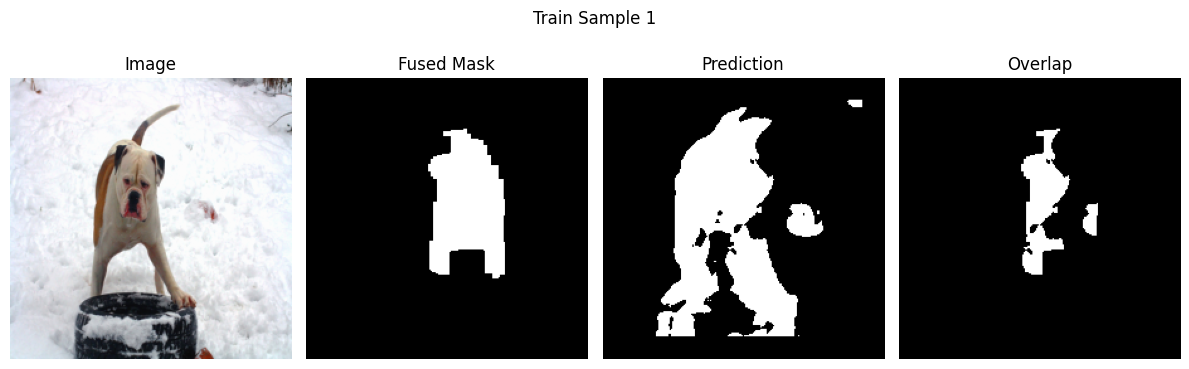

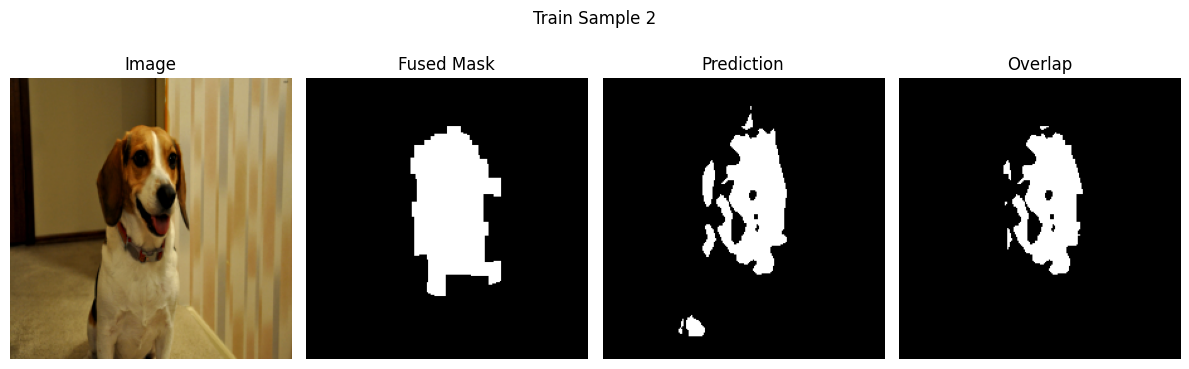

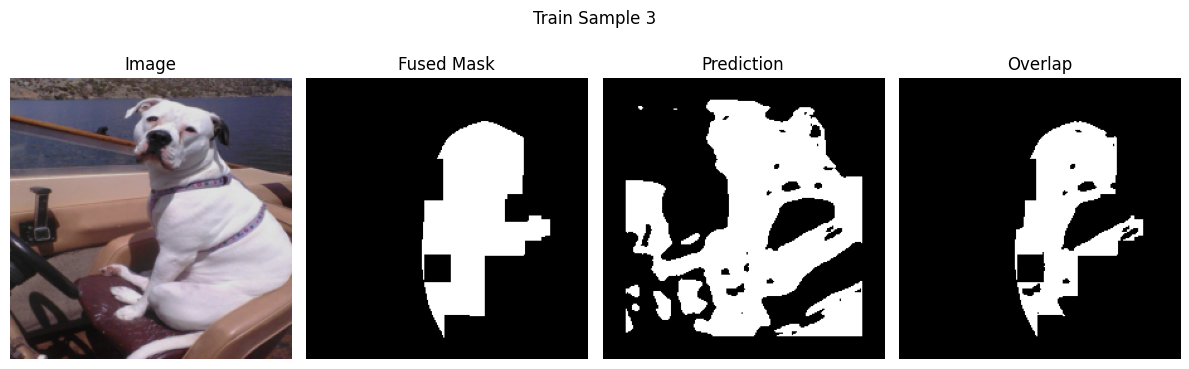

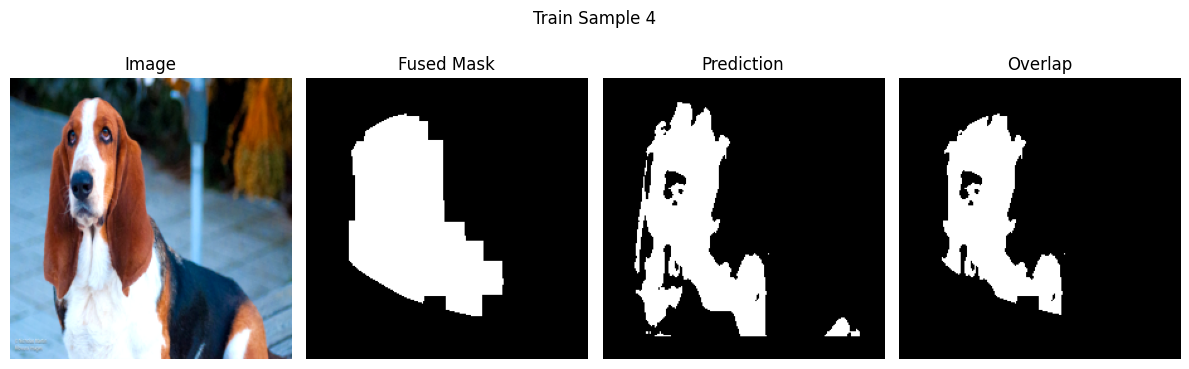

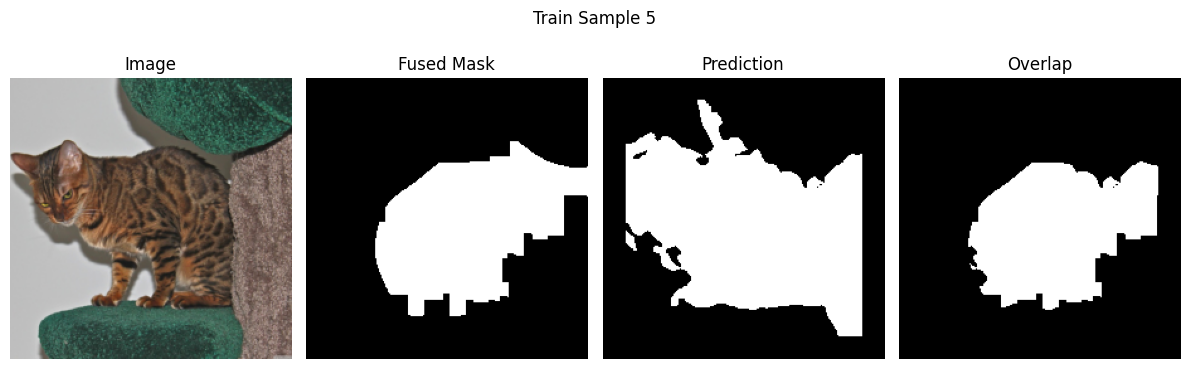

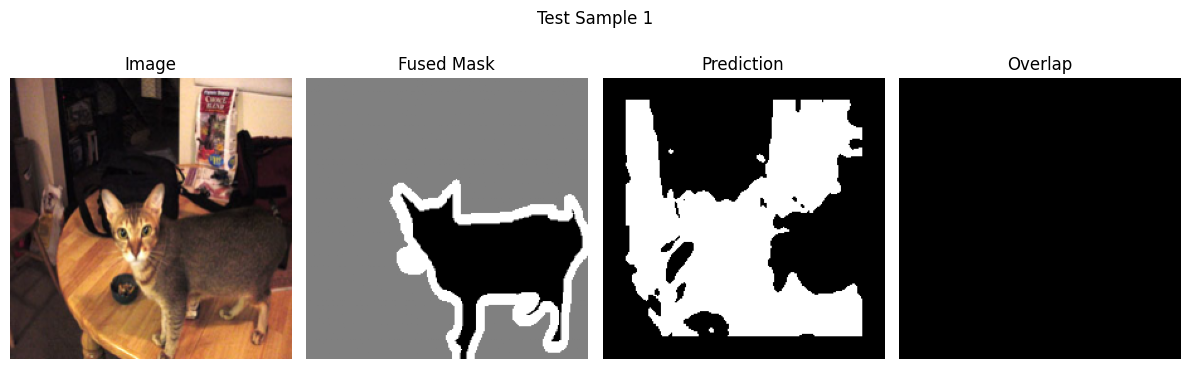

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms, models
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from transformers import AutoModel, AutoImageProcessor
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

trainval_dataset = OxfordIIITPet(root='./data', split='trainval', target_types='segmentation', transform=base_transform, download=True)
test_dataset = OxfordIIITPet(root='./data', split='test', target_types='segmentation', transform=base_transform, download=True)

class PseudoSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.files[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.files[idx])).convert("L")
        if self.transform:
            img = self.transform(img)
        else:
            img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        return img, mask

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )
        self.enc1 = CBR(3, 32)
        self.enc2 = CBR(32, 64)
        self.enc3 = CBR(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.dec2 = CBR(128 + 64, 64)
        self.dec1 = CBR(64 + 32, 32)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.dec2(torch.cat([F.interpolate(e3, scale_factor=2), e2], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, scale_factor=2), e1], dim=1))
        return self.final(d1)

train_set = PseudoSegDataset("pseudo_dataset_v2/images", "pseudo_dataset_v2/masks", transform=augment_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

def binarize_gt(gt_tensor):
    gt_np = gt_tensor.squeeze().numpy()
    return ((gt_np == 1) | (gt_np == 2)).astype(np.uint8)

class TestSegDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_tensor, gt_pil = self.dataset[idx]
        gt_tensor = TF.to_tensor(TF.resize(gt_pil, [224, 224]))
        return img_tensor, gt_tensor

test_tensor_dataset = TestSegDataset(test_dataset)
test_loader = DataLoader(test_tensor_dataset, batch_size=1, shuffle=False)

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def dice_loss(pred, target):
    smooth = 1e-6
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

criterion = lambda pred, mask: 0.5 * nn.BCEWithLogitsLoss()(pred, mask) + 0.5 * dice_loss(pred, mask)

for epoch in range(30):
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")

import matplotlib.pyplot as plt

def visualize_samples(loader, dataset_name="Train", num_samples=5, is_test=False):
    model.eval()
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = torch.sigmoid(model(imgs)) > 0.5
            preds = preds.cpu()
            imgs, masks = imgs.cpu(), masks.cpu()
            break 

    n = min(num_samples, imgs.size(0))

    for i in range(n):
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(imgs[i].permute(1, 2, 0))
        axs[0].set_title("Image")
        
        if is_test:
            gt_bin = ((masks[i][0].numpy() == 1) | (masks[i][0].numpy() == 2)).astype(np.uint8)
            axs[1].imshow(gt_bin, cmap='gray')
            axs[1].set_title("GT")
        else:
            axs[1].imshow(masks[i][0], cmap='gray')
            axs[1].set_title("Fused Mask")

        axs[2].imshow(preds[i][0], cmap='gray')
        axs[2].set_title("Prediction")

        axs[3].imshow((preds[i][0] > 0.5) & (masks[i][0] > 0.5), cmap='gray')
        axs[3].set_title("Overlap")

        for ax in axs:
            ax.axis("off")
        plt.suptitle(f"{dataset_name} Sample {i+1}")
        plt.tight_layout()
        plt.show()


visualize_samples(train_loader, "Train")
visualize_samples(test_loader, "Test")
